<a href="https://colab.research.google.com/github/a-mitani/pyro_code_examples/blob/main/model_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive
from pyro.infer.autoguide import AutoDiagonalNormal


np.random.seed(1)
pyro.set_rng_seed(1)

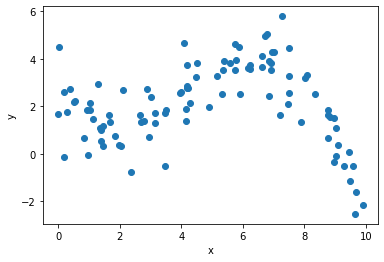

In [3]:
def create_poly_data(coef, size, x_max, sigma):
    x = np.random.rand(size) * x_max
    y = np.zeros(size)
    for i in range(len(coef)):
        y += coef[i] * x ** i
    y += np.random.normal(scale=sigma, size=size)
    return x, y

COEF = [2, -1.5, 0.6, -0.05]
# COEF = [3, 5, 0, -0.1]
X_MAX = 10
SIGMA = 1.0

x, y = create_poly_data(COEF, 100, X_MAX, SIGMA)
train = torch.tensor(np.array([x, y]).T, dtype=torch.float)

plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [4]:
def model(x, y, model_dim, sigma):
    param_dim = model_dim + 1
    w = pyro.sample("w", dist.Normal(0.0, 10.0).expand([param_dim]).to_event(1))
    mean = torch.zeros_like(x)
    for i in range(param_dim):
        mean += w[i] * (x ** i)
    with pyro.plate("data", len(x)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=y)

guide = AutoDiagonalNormal(model)

Elbo loss: 203900834.11646128
Elbo loss: 3771.803943634033
Elbo loss: 701.8683490753174
Elbo loss: 345.0684280395508
Elbo loss: 208.54803371429443
Elbo loss: 171.39434719085693
Elbo loss: 166.2162675857544
Elbo loss: 184.98296928405762
Elbo loss: 167.4419002532959
Elbo loss: 162.55823516845703


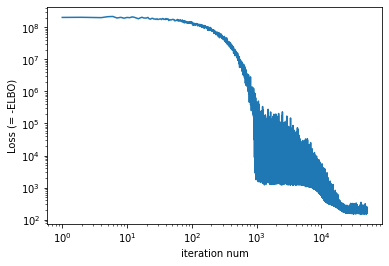

In [5]:
model_dim = 3
optimizer = pyro.optim.Adam({"lr": .01})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

x, y = train[:, 0], train[:, 1]
pyro.clear_param_store()
num_iters = 50000
iter_nums = []
losses = []
for i in range(num_iters):
    loss = svi.step(x, y, model_dim, SIGMA)
    iter_nums.append(i + 1)
    losses.append(loss)
    if i % (num_iters / 10) == 0:
        print("Elbo loss: {}".format(loss))

plt.plot(iter_nums, losses)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('iteration num')
plt.ylabel('Loss (= -ELBO)')
plt.show()

In [6]:
for name, value in pyro.get_param_store().items():
    print(name, value)

AutoDiagonalNormal.loc Parameter containing:
tensor([ 2.5502, -1.8158,  0.6533, -0.0535], requires_grad=True)
AutoDiagonalNormal.scale tensor([0.0949, 0.0155, 0.0024, 0.0003], grad_fn=<AddBackward0>)


In [7]:
X_range = torch.tensor(np.linspace(0, X_MAX, 50))

predictive = Predictive(model=model, guide=guide, num_samples=1000, return_sites=["w", "obs"])
predict_samples = predictive.get_samples(X_range, None, model_dim, SIGMA)

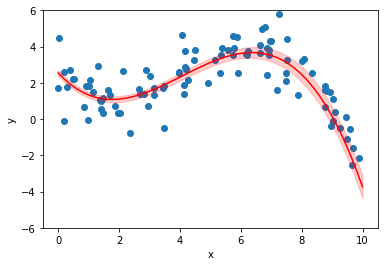

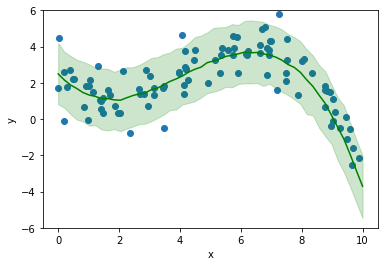

In [8]:
def plot_conf_interval(x, y, sampled_x, sampled_y, color):
    mean_vals = sampled_y.mean(0)
    percent05_vals = sampled_y.kthvalue(int(sampled_y.shape[0] * 0.05), dim=0)[0]
    percent95_vals = sampled_y.kthvalue(int(sampled_y.shape[0] * 0.95), dim=0)[0]

    plt.scatter(x, y)
    plt.plot(sampled_x, mean_vals, color=color)
    plt.fill_between(sampled_x, percent05_vals, percent95_vals, color=color, alpha=0.2)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.ylim((-6.0, 6.0))
    plt.show()

sampled_vals = torch.zeros((1000, 50))
for i in range(model_dim + 1):
    sampled_vals += predict_samples["w"][:, :, i] * (X_range ** i)

plot_conf_interval(x, y, X_range, sampled_vals, 'r')

sampled_obs = predict_samples["obs"]
plot_conf_interval(x, y, X_range, sampled_obs, 'g')

In [9]:
SAMPLE_NUM = 1000
predictive = Predictive(model=model, guide=guide, num_samples=SAMPLE_NUM, return_sites=["w"])
predict_samples = predictive.get_samples(x, None, model_dim, SIGMA)

predicted_mean = torch.zeros((SAMPLE_NUM, len(x)))
for i in range(model_dim + 1):
    predicted_mean += predict_samples["w"][:, :, i] * (x ** i)

sum_log_prob = torch.zeros(SAMPLE_NUM)
for i in range(len(x)):
    normal_1d = dist.Normal(predicted_mean[:, i], SIGMA)
    sum_log_prob = normal_1d.log_prob(y[i])
log_marginal_likelihood = torch.mean(sum_log_prob)
print("log_marginal_likelihood = ", log_marginal_likelihood.item())

log_marginal_likelihood =  -0.9372764825820923
